In [1]:
# Import raw data from Excel
import pandas as pd
filepath = 'C:/Users/PXY/Desktop/Orange_week.xlsx';
sheetname = 'main'
df = pd.read_excel ( filepath, sheet_name = sheetname );
print (df)

     Year    Week  Cases  Rainfalls  No.of Raindays  Max. temperature  \
0    2010   week1    NaN        NaN             NaN               NaN   
1    2010   week2    NaN        NaN             NaN               NaN   
2    2010   week3    NaN        NaN             NaN               NaN   
3    2010   week4    NaN      286.0            22.0         32.883871   
4    2010   week5    NaN        NaN             NaN               NaN   
5    2010   week6    NaN        NaN             NaN               NaN   
6    2010   week7    NaN        NaN             NaN               NaN   
7    2010   week8   36.0      241.8            11.0         34.385714   
8    2010   week9   65.0        NaN             NaN               NaN   
9    2010  week10   46.0        NaN             NaN               NaN   
10   2010  week11   31.0        NaN             NaN               NaN   
11   2010  week12   27.0      191.8            14.0         34.338710   
12   2010  week13   40.0        NaN             NaN

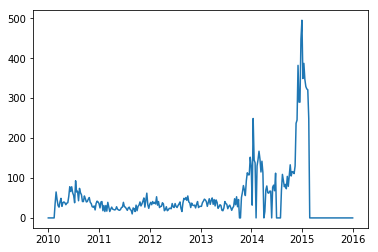

In [51]:
# Data preprocessing
# Set NaN to 0.0 for Cases & Fatality
df['Cases'].fillna( 0, inplace = True )
df['Fatality'].fillna(0, inplace = True )

# Set others to first found values
df['Rainfalls'].ffill( inplace = True );
df['Max. temperature'].ffill( inplace = True );
df['Min. temperature'].ffill( inplace = True );
df['Mean temp'].ffill( inplace = True );

# Ffill doesn't fill in the first three NaN, thus need to do another bfill
df['Rainfalls'].bfill( inplace = True );
df['Max. temperature'].bfill( inplace = True );
df['Min. temperature'].bfill( inplace = True );
df['Mean temp'].bfill( inplace = True );

# Add new column
import datetime 
date = []
for index,row in df.iterrows():
    row['Date'] = datetime.datetime.strptime( str( row['Year'])+ row['Week'] + "-1", "%Yweek%W-%w")
    date.append( row['Date'])

df['Date'] = date

# Verify if all the anomalies are gone and new column added succesfully
df.dtypes

# Create a new data frame
data = pd.DataFrame()
data['Date'] = df['Date']
data['Rainfalls'] = df['Rainfalls'];
data['Max. temperature'] = df['Max. temperature']
data['Min. temperature'] = df['Min. temperature']
data['Mean temp'] = df['Mean temp']
data['Cases'] = df['Cases']

# Show the data in chart
import matplotlib
import matplotlib.pyplot as plt
plt.figure()
dates = matplotlib.dates.date2num(df['Date'])
plt.plot_date(dates, df['Cases'], linestyle = 'solid', marker = 'None')

In [43]:
# Normalizing data
# This step is really useful on improving model performance
import sklearn
from sklearn.preprocessing import MinMaxScaler
cols_to_norm = [ 'Rainfalls','Max. temperature','Min. temperature','Mean temp','Cases']
sc = MinMaxScaler();
scaled_data = data.copy()
scaled_data[cols_to_norm] = sc.fit_transform(data[cols_to_norm])
 
# Split into train and test sets",
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = scaled_data[:train_size], scaled_data.tail(test_size)

# Get the subset of the data for training
training_set = train.iloc[:, 1:6].values

# Create input for training
import numpy as np
X_train = []
y_train =[]
for i in range(60, len(training_set)):
    X_train.append(training_set[i-60:i,0]);
    y_train.append(training_set[i,4])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))   

149

In [22]:
# Build and train the model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

regressor = tf.keras.Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
149/149 [==============================] - 7s 44ms/sample - loss: 0.0046
Epoch 2/100
149/149 [==============================] - 3s 18ms/sample - loss: 0.0025
Epoch 3/100
149/149 [==============================] - 3s 18ms/sample - loss: 0.0023
Epoch 4/100
149/149 [==============================] - 3s 18ms/sample - loss: 0.0021
Epoch 5/100
149/149 [==============================] - 3s 18ms/sample - loss: 0.0019
Epoch 6/100
149/149 [==============================] - 3s 18ms/sample - loss: 0.0018
Epoch 7/100
149/149 [==============================] - 3s 18ms/sample - loss: 0.0019
Epoch 8/100
149/149 [==============================] - 3s 19ms/sample - loss: 0.0018
Epoch 9/100
149/149 [==============================] - 3s 18ms/sample - loss: 0.0019
Epoch 10/100
149/149 [==============================] - 3s 18ms/sample - loss: 0.0017
Epoch 11/100
149/149 [==============================] - 3s 18ms/sample - loss: 0.0017
Epoch 12/100
149/149 [==============================] - 3s 18ms

149/149 [==============================] - 3s 19ms/sample - loss: 9.8815e-04
Epoch 97/100
149/149 [==============================] - 3s 18ms/sample - loss: 9.3128e-04
Epoch 98/100
149/149 [==============================] - 3s 18ms/sample - loss: 9.0218e-04
Epoch 99/100
149/149 [==============================] - 3s 19ms/sample - loss: 0.0011
Epoch 100/100
149/149 [==============================] - 3s 19ms/sample - loss: 9.7149e-04


In [44]:
# Create test data
test_set = test.iloc[:, 1:4].values
inputs = test_set.reshape(-1,1)
real_cases = data['Cases'].tail(test_size).values

X_test = []
for i in range(60, len(test) + 60):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_cases = regressor.predict(X_test)

result = np.zeros(shape=(len(predicted_cases),5))
result[:,0] = predicted_cases[:,0]
predict = sc.inverse_transform(result)[:,0]

print(predict )

[39.52136622 39.12773838 39.21988884 39.32272488 39.44114538 39.76811552
 40.0191408  40.24044296 40.50521738 40.79443705 40.88863513 41.01920632
 41.16860624 41.11300084 41.09960087 41.11395886 40.95965304 40.85965597
 40.79733918 40.70458338 40.437635   40.33705539 40.2790181  40.11167551
 40.076764   40.08270687 40.02037956 40.04388082 40.09522954 40.10132857
 40.15266149 40.203554   40.22296176 40.25906641 40.32248158 40.37761675
 40.46182232 40.58067972 40.70878743 40.85975071 41.03284667 41.21705107
 41.40570868 41.59347319 41.79308133 42.00064313 42.1944628  42.40428278
 42.61960523 42.78362984 42.98097102 43.17827711 43.28053237 43.44894352
 43.6173722  43.8096794  43.95978468 44.0537266  44.18580324 44.26473269
 44.28181559 44.33189221 44.34215669 44.31067896 44.3131319  44.30446061
 44.28542307 44.28694959 44.30779437 44.31584278 44.32736882 44.37569083
 44.41364133 44.44127822 44.51861097 44.57566042 44.61699732 44.70844417
 44.7565837  44.78457853 44.87790282 44.89883534 44

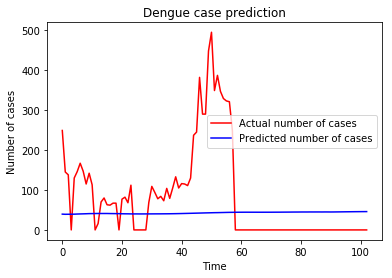

In [41]:
# Visualising the results
plt.plot(real_cases, color = 'red', label = 'Actual number of cases')
plt.plot(predict, color = 'blue', label = 'Predicted number of cases')
plt.title('Dengue case prediction')
plt.xlabel('Time')
plt.ylabel('Number of cases')
plt.legend()
plt.show()